<a href="https://colab.research.google.com/github/torrhen/cable-temperature-prediction/blob/master/cable_temperature_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# data GitHub URL
DATA_CSV_URL = "https://raw.githubusercontent.com/torrhen/cable-temperature-prediction/dev/cable.csv"

In [2]:
import os
# create new project folder
os.makedirs('cable_temperature_prediction', exist_ok=True)

In [3]:
import torch
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## cable_temperature_prediction/data.py

In [5]:
#%writefile cable_temperature_prediction/data.py
import pandas as pd
import datetime as dt
import numpy as np
import torch

STANDARD_DEVIATION_OUTLIER_THRESHOLD = 2
ROUNDING_PRECISION = 3

# create dataframe from raw data taken from GitHub repository
def create_dataframe(url):
  # set the timestamp column as the index of the dataframe
  df = pd.read_csv(url, index_col=0, parse_dates=[0], infer_datetime_format=True)
  # resample data to ensure no missing timestamps
  df = df.resample("30min").mean()
  # replace all nan values using the last valid observation for every column
  df = df.pad() # pad() is equivalent to fillna(method="ffill")
  df = df.round(ROUNDING_PRECISION)
  # remove values outside 2 SD of the mean of each calendar month
  df = remove_outliers(df)
  
  return df

# group data by calendar month and replace values outside 2 SD of the mean with the last valid observed value for every column
def remove_outliers(df):
  # add new column string the integer month of each timestamp
  df["month"] = df.index.month

  # replace data points beyond 2 SD of the mean for each calendar month with np.nan
  def remove_data(group, std):
    group[np.abs(group - group.mean()) > std * group.std()] = np.nan
    return group

  transformed_df = df.groupby("month", as_index=False).transform(lambda x: remove_data(x, STANDARD_DEVIATION_OUTLIER_THRESHOLD))
  # fill empty data with the last valid observation for all columns
  transformed_df = transformed_df.fillna(method="ffill").round(ROUNDING_PRECISION)
  # remove integer month column
  df.drop(columns=["month"], inplace=True)

  return transformed_df


In [6]:
# create dataframe from data downloaded from GitHUb
df = create_dataframe(DATA_CSV_URL)

In [7]:
# create a new feature using the mean of each phase of the current load
phase_df = df[['Phase (Blue)', 'Phase (Yellow)', 'Phase (Red)']]
df['Load'] = phase_df.mean(axis=1).round(3)

In [8]:
# drop features that are not necessary for training
X_df = df.drop(['Thermocouple 4', 'Thermocouple 6', 'Thermocouple 7', 'Phase (Blue)', 'Phase (Yellow)', 'Phase (Red)', 'Air Temperature'], axis=1)

In [9]:
# create a new dataframe of the target feature to predict
y_df = X_df.pop('Thermocouple 5')
# the targets to predict will be shifted 1 time interval ahead
y_df = y_df[1:]
# convert to numpy array
y = y_df.values

In [10]:
# ensure the shifted target for the final data point does not fall beyond the end of the dataframe
X_df = X_df[:-1]
# convert to numpy array
X = X_df.values

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# split the sequential data into training and test dataframes without shuffling 
train_X, test_X, train_y, test_y = train_test_split(X,  y, test_size=0.2, shuffle=False)

# normalize data
normalizer = MinMaxScaler()
# fit normalizer to training data
train_X = normalizer.fit_transform(train_X)
# normalize test data using the same training data normalizer transform
test_X = normalizer.transform(test_X)

In [12]:
from torch.utils.data import Dataset

# custom data set for pytorch
class CableDataset(Dataset):
  def __init__(self, X, y):
    super(CableDataset, self).__init__()
    assert(len(X) == len(y))
    # convert numpy X and y data into tensors
    self.X = torch.from_numpy(X).type(torch.float32)
    self.y = torch.from_numpy(y).type(torch.float32)

  # override
  def __len__(self):
    return len(self.X)
    
  # override
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [13]:
# create custom pytorch training and test data tensors
train_data = CableDataset(train_X, train_y)
test_data = CableDataset(test_X, test_y)

print(f"Train X shape: {train_data.X.shape}")
print(f"Train y shape: {train_data.y.shape}")
print(f"Test X shape: {test_data.X.shape}")
print(f"Test y shape: {test_data.y.shape}")

Train X shape: torch.Size([7679, 4])
Train y shape: torch.Size([7679])
Test X shape: torch.Size([1920, 4])
Test y shape: torch.Size([1920])


In [14]:
from torch.utils.data import DataLoader

# divide the training and test data into batches without shuffling since data is sequential.
train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

print(f'Train data loader contains {len(train_data)} samples within {len(train_dataloader)} batches')
print(f'Test data loader contains {len(test_data)} samples within {len(test_dataloader)} batches')

Train data loader contains 7679 samples within 120 batches
Test data loader contains 1920 samples within 30 batches


## cable_temperature_prediction/models.py

In [15]:
from torch import nn

# custom RNN model
class RecurrentNeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    # initialize base class
    super(RecurrentNeuralNetwork, self).__init__()
    # store class attributes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    # store model layers
    self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, nonlinearity='relu', batch_first=True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)

  # reset the hidden state to all zeroes
  def reset_state(self):
    self.hidden_state = torch.zeros(self.num_layers, self.hidden_size).to(device)

  def forward(self, x):
    # calculate new output and hidden state
    output, hidden = self.rnn(x, self.hidden_state.detach())
    self.hidden_state = hidden
    # pass current output to fully connected network to create a single continous output
    output = self.fc(output)

    return output

# custom LSTM model
class LongShortTermMemoryNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    # initialize base class
    super(LongShortTermMemoryNetwork, self).__init__()
    # store attributes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    # store model layers
    self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
    self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)

  # reset the hidden state and cell state to all zeroes
  def reset_state(self):
    self.hidden_state = torch.zeros(self.num_layers, self.hidden_size).to(device)
    self.cell_state = torch.zeros(self.num_layers, self.hidden_size).to(device)

  def forward(self, x):
    # calculate new output, hidden state and cell state
    output, hidden = self.lstm(x, (self.hidden_state.detach(), self.cell_state.detach()))
    self.hidden_state = hidden[0]
    self.cell_state = hidden[1]
    # pass output through fully connected layer
    output = self.fc(output)

    return output

# custom GRU
class GatedRecurrentUnitNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(GatedRecurrentUnitNetwork, self).__init__()
    # store attributes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    # store model layers
    self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
    self.fc = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)

  # reset the hidden state to all zeroes
  def reset_state(self):
    self.hidden_state = torch.zeros(self.num_layers, self.hidden_size).to(device)

  def forward(self, x):
    # calculate new output and hidden state
    output, hidden = self.gru(x, self.hidden_state.detach())
    self.hidden_state = hidden
    # pass output through fully connected layer
    output = self.fc(output)

    return output

## cable_temperature_prediction/train.py

In [16]:
# train step
def train_step(model, dataloader, loss_fn, optimizer, device):
  train_loss = 0.0
  # training mode
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    # allocate data to device
    X, y = X.to(device), y.to(device)
    # forward pass
    output = model(X)
    # calculate loss
    loss = loss_fn(output, y)
    train_loss += loss
    # prevent accumulation of gradients
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # gradient descent update
    optimizer.step()
  
  train_loss /= len(dataloader)

  return train_loss

In [17]:
# test step
def test_step(model, dataloader, loss_fn, device):
  test_loss = 0.0
  # evaluation mode
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # allocate data to device
      X, y = X.to(device), y.to(device)
      # forward pass
      output = model(X)
      # calculate loss
      loss = loss_fn(output, y)
      test_loss += loss
      
    test_loss /= len(dataloader)
    #print(test_loss)
  
  return test_loss

In [18]:
# train and test model
def train(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=10):
  # store results of model at each epoch
  results = {'train_loss':[], 'test_loss':[]}

  for epoch in range(epochs):
    # reset the hidden state and or cell state of the model at the start of each epoch
    model.reset_state()

    # train and evaluate the model
    train_loss = train_step(model, train_loader, loss_fn, optimizer, device)
    test_loss = test_step(model, test_loader, loss_fn, device)

    # display statistics at each epoch
    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f}")
    # store results
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)

  return results

### cable_temperature_predictions/predict.py

In [19]:
import matplotlib.pyplot as plt

# make predictions on the test set
def make_predictions(model, test_dataloader, device):
  # store list of batch predictions
  batch_preds = []
  # turn off training settings
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      # allocate to device
      X, y = X.to(device), y.to(device)
      # calculate logits
      output = model_0(X)
      # store batch predictions
      batch_preds.append(output.cpu())
      
  # concatenate batch predictions into single tensor
  return torch.cat(batch_preds)

def plot_predictions(y_pred, y_true=None):
  # setup plot
  plt.figure(figsize=(15,10))
  # plot predictions for the test data
  plt.plot(y_pred.cpu().numpy(), label='predicted temperature')
  # plot true targets if given
  if y_true is not None:
    plt.plot(y_true.cpu().numpy(), label='true temperatbitcoinure')
  # label plot axes
  plt.xlabel('30 minute intervals')
  plt.ylabel('Temperature of Thermocouple 5 (C)')
  plt.grid(True)
  plt.legend()
  plt.show()

def plot_predictions_error(y_pred, y_true):
  # calculate error
  error = y_true.unsqueeze(dim=1).sub(y_pred)
  # setup plot
  plt.figure(figsize=(15,10))
  # plot the real - predicted error
  plt.plot(error, label='real-predicted', c='r')
  # label plot axes
  plt.xlabel('30 minute intervals')
  plt.ylabel('Temperature of Thermocouple 5 (C)')
  plt.grid(True)
  plt.legend()
  plt.show()

### RNN Model

In [20]:
# initialize custom model [num_features, hidden_size, output_size, num_layers] and allocate to device
model_0 = RecurrentNeuralNetwork(4, 8, 1, 1).to(device)
model_0_test = RecurrentNeuralNetwork(4, 8, 1, 1).to(device)
model_0_test.reset_state()
# print a summary of the model using a generic input shape
summary(model_0_test, input_size=(64, 4), col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
RecurrentNeuralNetwork                   [64, 4]                   [64, 1]                   True
├─RNN: 1-1                               [64, 4]                   [64, 8]                   True
├─Linear: 1-2                            [64, 8]                   [64, 1]                   True
Total params: 121
Trainable params: 121
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [21]:
# mean squared error loss function
loss_fn = nn.MSELoss()
# Adam optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01, weight_decay=0.01)

In [22]:
# run RNN model and display results
model_0_results = train(model_0, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs=10)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 | Train Loss: 102.08158 | Test Loss: 1.74657
Epoch: 2 | Train Loss: 1.70307 | Test Loss: 1.52248
Epoch: 3 | Train Loss: 1.44107 | Test Loss: 1.34892
Epoch: 4 | Train Loss: 0.96861 | Test Loss: 0.89657
Epoch: 5 | Train Loss: 0.65656 | Test Loss: 0.53384
Epoch: 6 | Train Loss: 0.46122 | Test Loss: 0.29837
Epoch: 7 | Train Loss: 0.33858 | Test Loss: 0.18184
Epoch: 8 | Train Loss: 0.27081 | Test Loss: 0.14179
Epoch: 9 | Train Loss: 0.22542 | Test Loss: 0.10378
Epoch: 10 | Train Loss: 0.19079 | Test Loss: 0.08520


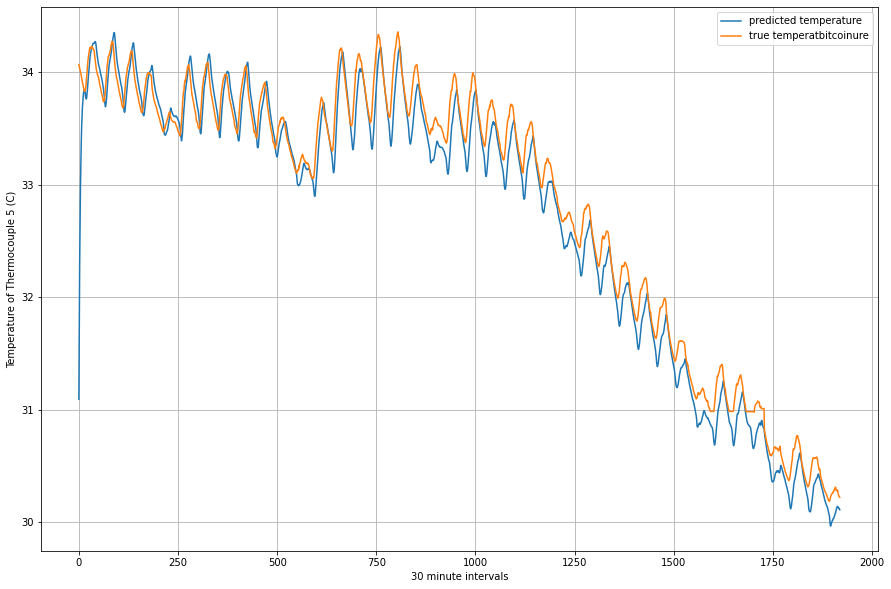

In [23]:
# make predictions with RNN model
y_preds = make_predictions(model_0, test_dataloader, device)
# plot predictions of RNN model
plot_predictions(y_preds, test_data.y)

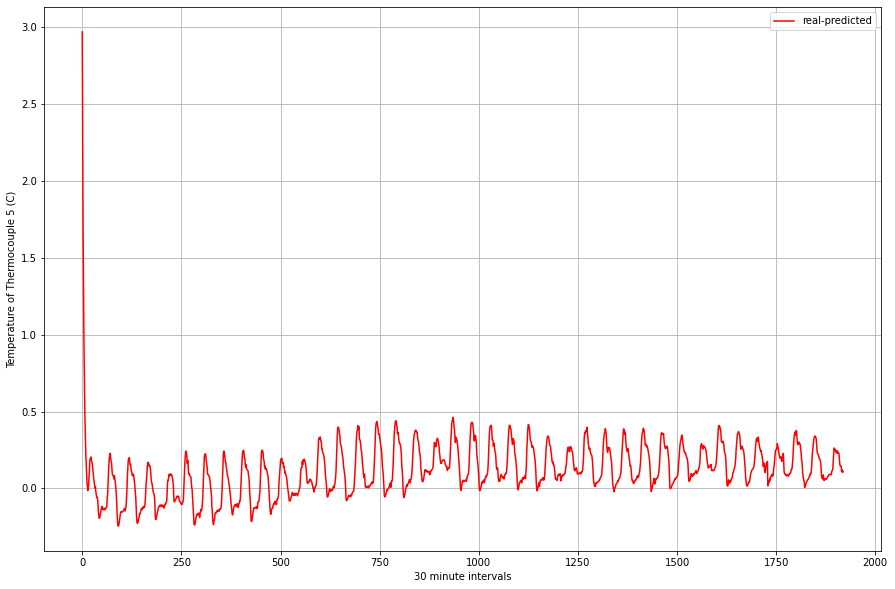

In [24]:
# plot prediction error of RNN model
plot_predictions_error(y_preds, test_data.y)

### LSTM Model

In [25]:
# initialize custom model [num_features, hidden_size, output_size, num_layers] and allocate to device
model_1 = LongShortTermMemoryNetwork(4, 16, 1, 1).to(device)
model_1_test = LongShortTermMemoryNetwork(4, 16, 1, 1).to(device)
model_1_test.reset_state()
# print a summary of the model using a generic input shape
summary(model_1_test, input_size=(64, 4), col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
LongShortTermMemoryNetwork               [64, 4]                   [64, 1]                   True
├─LSTM: 1-1                              [64, 4]                   [64, 16]                  True
├─Linear: 1-2                            [64, 16]                  [64, 1]                   True
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
Total mult-adds (M): 1.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

In [26]:
# set up loss function
loss_fn = nn.MSELoss()
# set up optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01, weight_decay=0.01)

In [27]:
# run LSTM model and display results
model_1_results = train(model_1, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs=20)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 | Train Loss: 181.59114 | Test Loss: 86.66588
Epoch: 2 | Train Loss: 33.82823 | Test Loss: 22.47472
Epoch: 3 | Train Loss: 49.89003 | Test Loss: 23.69479
Epoch: 4 | Train Loss: 44.04938 | Test Loss: 26.16359
Epoch: 5 | Train Loss: 23.30000 | Test Loss: 13.89442
Epoch: 6 | Train Loss: 14.32829 | Test Loss: 2.57776
Epoch: 7 | Train Loss: 10.15254 | Test Loss: 1.28742
Epoch: 8 | Train Loss: 1.57849 | Test Loss: 0.88124
Epoch: 9 | Train Loss: 0.19992 | Test Loss: 0.63306
Epoch: 10 | Train Loss: 0.13030 | Test Loss: 0.55070
Epoch: 11 | Train Loss: 0.09702 | Test Loss: 0.52266
Epoch: 12 | Train Loss: 0.08508 | Test Loss: 0.51753
Epoch: 13 | Train Loss: 0.07898 | Test Loss: 0.59615
Epoch: 14 | Train Loss: 0.07176 | Test Loss: 0.72796
Epoch: 15 | Train Loss: 0.06361 | Test Loss: 0.85414
Epoch: 16 | Train Loss: 0.06175 | Test Loss: 1.00671
Epoch: 17 | Train Loss: 0.06391 | Test Loss: 0.97963
Epoch: 18 | Train Loss: 0.06470 | Test Loss: 0.90980
Epoch: 19 | Train Loss: 0.07136 | Test Los

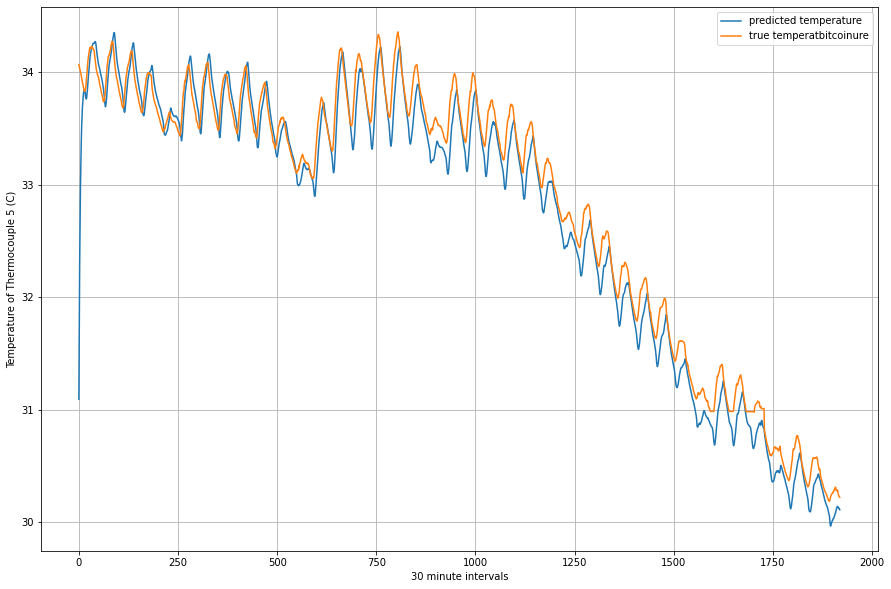

In [28]:
# make predictions with LSTM model
y_preds = make_predictions(model_1, test_dataloader, device)
# plot predictions of LSTM model
plot_predictions(y_preds, test_data.y)

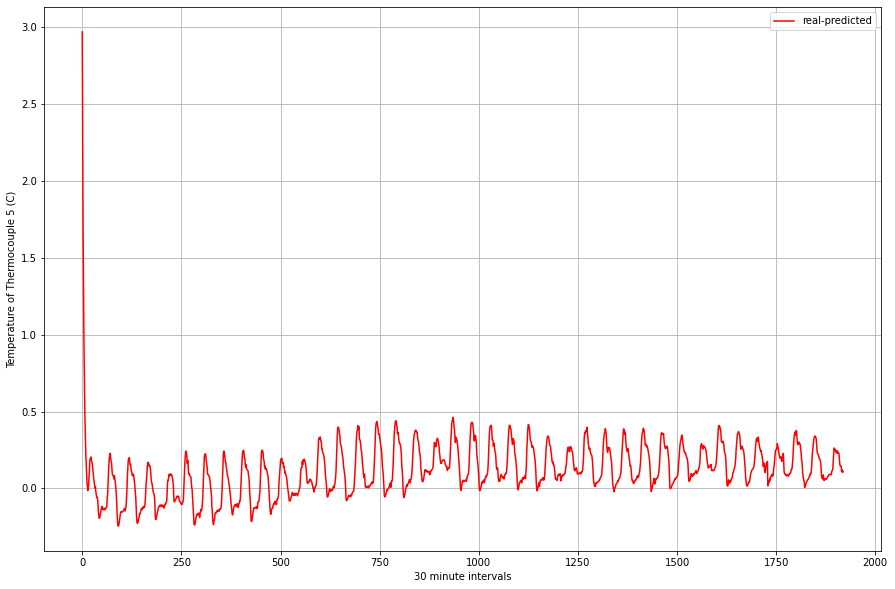

In [29]:
# plot prediction error of LSTM model
plot_predictions_error(y_preds, test_data.y)

### GRU Model

In [30]:
# initialize custom model [num_features, hidden_size, output_size, num_layers] and allocate to device
model_2 = GatedRecurrentUnitNetwork(4, 8, 1, 1).to(device)
model_2_test = GatedRecurrentUnitNetwork(4, 8, 1, 1).to(device)
model_2_test.reset_state()
# print a summary of the model using a generic input shape
summary(model_2_test, input_size=(64, 4), col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
GatedRecurrentUnitNetwork                [64, 4]                   [64, 1]                   True
├─GRU: 1-1                               [64, 4]                   [64, 8]                   True
├─Linear: 1-2                            [64, 8]                   [64, 1]                   True
Total params: 345
Trainable params: 345
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [31]:
# set up loss function
loss_fn = nn.MSELoss()
# set up optimizer
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.01, weight_decay=0.01)

In [32]:
# run GRU model and display results
model_2_results = train(model_2, train_dataloader, test_dataloader, loss_fn, optimizer, device, epochs=20)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 | Train Loss: 357.41241 | Test Loss: 373.71060
Epoch: 2 | Train Loss: 107.97218 | Test Loss: 155.57507
Epoch: 3 | Train Loss: 47.81877 | Test Loss: 75.43971
Epoch: 4 | Train Loss: 35.02222 | Test Loss: 40.98979
Epoch: 5 | Train Loss: 22.98199 | Test Loss: 24.23027
Epoch: 6 | Train Loss: 7.24705 | Test Loss: 11.98066
Epoch: 7 | Train Loss: 3.93522 | Test Loss: 5.91594
Epoch: 8 | Train Loss: 3.06196 | Test Loss: 3.13326
Epoch: 9 | Train Loss: 1.91949 | Test Loss: 1.76576
Epoch: 10 | Train Loss: 1.11842 | Test Loss: 1.17582
Epoch: 11 | Train Loss: 0.68309 | Test Loss: 0.99838
Epoch: 12 | Train Loss: 0.36979 | Test Loss: 1.09967
Epoch: 13 | Train Loss: 0.36263 | Test Loss: 1.57309
Epoch: 14 | Train Loss: 6.70384 | Test Loss: 10.28009
Epoch: 15 | Train Loss: 3.04563 | Test Loss: 3.82789
Epoch: 16 | Train Loss: 1.40384 | Test Loss: 1.49427
Epoch: 17 | Train Loss: 0.91786 | Test Loss: 1.02496
Epoch: 18 | Train Loss: 0.39297 | Test Loss: 1.31430
Epoch: 19 | Train Loss: 0.16279 | Test 

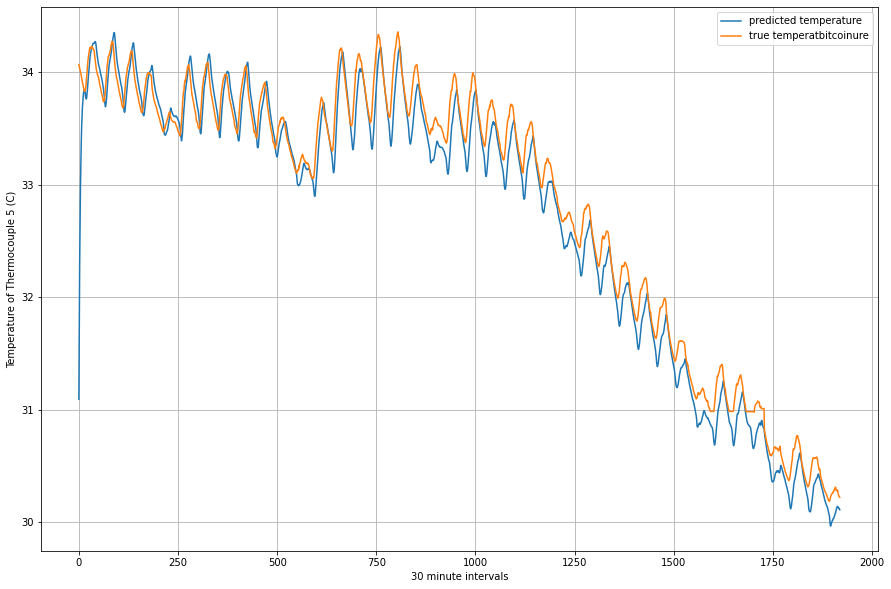

In [33]:
# make predictions with GRU model
y_preds = make_predictions(model_2, test_dataloader, device)
# plot predictions of GRU model
plot_predictions(y_preds, test_data.y)

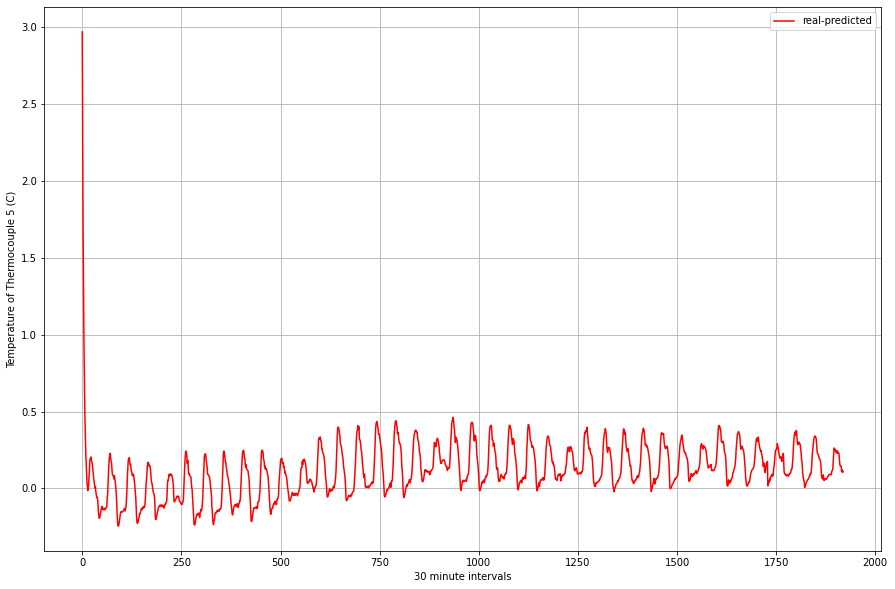

In [34]:
# plot prediction error of GRU model
plot_predictions_error(y_preds, test_data.y)